<h1>Breaking Acceleration Exploration</h1>

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import datetime
import cftime
from scipy import signal
import os
%matplotlib widget


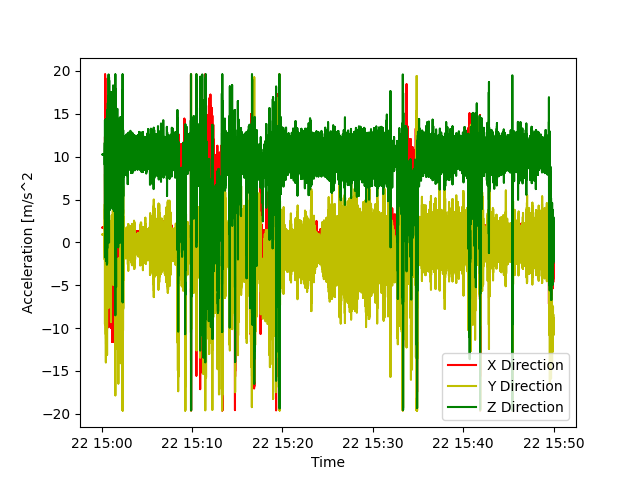

In [6]:
# Get Data set from mission 52 due to better notes on when in breaking 
mission_nc_path = '../microSWIFT_data/mission_52/mission_52.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')

# Get list of microSWIFTs during this deployment
microSWIFTs_on_mission = list(mission_dataset.groups.keys())
num_micros = len(microSWIFTs_on_mission)

# Get actual datetime objects from netcdf time
accel_time_40 = cftime.num2pydate(mission_dataset['microSWIFT_40']['IMU']['time'], units=mission_dataset['microSWIFT_40']['IMU']['time'].units, calendar=mission_dataset['microSWIFT_40']['IMU']['time'].calendar)

# Plot the Accelerations in all three directions for each micro
fig_micro_1, ax = plt.subplots()
ax.plot(accel_time_40, mission_dataset['microSWIFT_40']['IMU']['accel_x'], color='r', label='X Direction')
ax.plot(accel_time_40, mission_dataset['microSWIFT_40']['IMU']['accel_y'], color='y', label='Y Direction')
ax.plot(accel_time_40, mission_dataset['microSWIFT_40']['IMU']['accel_z'], color='g', label='Z Direction')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration [m/s^2')



Text(0, 0.5, 'Sum of Variance')

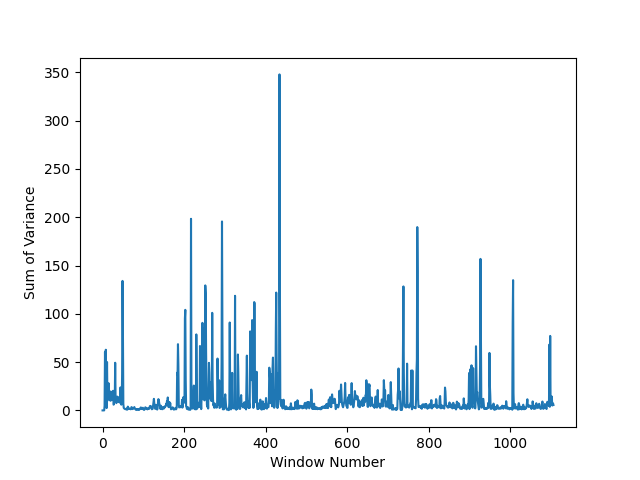

In [20]:
# Define Accelerations 
accel_time = mission_dataset['microSWIFT_40']['IMU']['time']
accel_x = mission_dataset['microSWIFT_40']['IMU']['accel_x']
accel_y = mission_dataset['microSWIFT_40']['IMU']['accel_y']
accel_z = mission_dataset['microSWIFT_40']['IMU']['accel_z']

# Sort Data into short windows of 32 samples
sample_per_window = 32 # This value is chosen from the Brown 2018 paper
imu_sampling_freq = 12 # Units are Hz
time_per_window = sample_per_window * (1/imu_sampling_freq) # Time per each window 
num_samples = len(accel_x)
num_windows = int(num_samples/sample_per_window)
num_samples_to_use = int(num_windows * sample_per_window)
# Reshape the python array to be windowed
accel_time_windowed = accel_time[:num_samples_to_use].reshape(sample_per_window, num_windows, order='F')
accel_x_windowed = accel_x[:num_samples_to_use].reshape(sample_per_window, num_windows, order='F')
accel_y_windowed = accel_y[:num_samples_to_use].reshape(sample_per_window, num_windows, order='F')
accel_z_windowed = accel_z[:num_samples_to_use].reshape(sample_per_window, num_windows, order='F')

# For each window - compute the variance and add together to get breaker index
sum_variance = np.empty(num_windows)
window_time = np.empty(num_windows)
for n in np.arange(num_windows):
    sum_variance[n] = np.var(accel_x_windowed[:,n]) + np.var(accel_y_windowed[:,n]) + np.var(accel_z_windowed[:,n])
    window_time[n] = np.mean(accel_time_window)


fig_var, ax = plt.subplots()
ax.plot(sum_variance)
ax.set_xlabel('Window Number')
ax.set_ylabel('Sum of Variance')


In [24]:
# Make Spectorgram of accelerations 
imu_sampling_freq = 12 # Units are Hz
f_accel_x_40, t_accel_x_40, Sxx_accel_x_40 = signal.spectrogram(mission_dataset['microSWIFT_40']['IMU']['accel_x'], fs=imu_sampling_freq)

# Plot Acceleration Spectrograms
fig_accel_x_spec, ax = plt.subplots()
ax.pcolor(t_accel_x_40, f_accel_x_40, Sxx_accel_x_40)



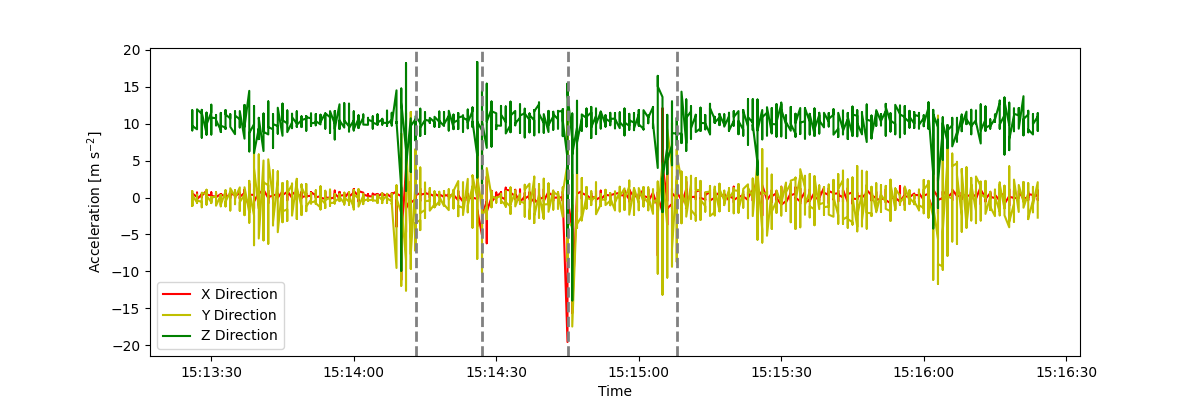

In [4]:
tstart = datetime.datetime(2021, 10, 22, 15, 13, 25)
tend = datetime.datetime(2021, 10, 22, 15, 16, 25)

tind = np.where((np.asarray(accel_time_40)>tstart) & (np.asarray(accel_time_40)<tend))[0]

xaccel = mission_dataset['microSWIFT_40']['IMU']['accel_x']
yaccel = mission_dataset['microSWIFT_40']['IMU']['accel_y']
zaccel = mission_dataset['microSWIFT_40']['IMU']['accel_z']

# Make Spectorgram of accelerations 
imu_sampling_freq = 12 # Units are Hz
f_accel_x_40, t_accel_x_40, Sxx_accel_x_40 = signal.spectrogram(xaccel[tind], fs=imu_sampling_freq)
f_accel_y_40, t_accel_y_40, Syy_accel_y_40 = signal.spectrogram(yaccel[tind], fs=imu_sampling_freq)
f_accel_z_40, t_accel_z_40, Szz_accel_z_40 = signal.spectrogram(zaccel[tind], fs=imu_sampling_freq)

# plot time series during set of breaking
breaking_tinds = np.array([datetime.datetime(2021, 10, 22, 15, 14, 13), datetime.datetime(2021, 10, 22, 15, 14, 27), 
                           datetime.datetime(2021, 10, 22, 15, 14, 45), datetime.datetime(2021, 10, 22, 15, 15, 8)])

fig_micro_1, ax = plt.subplots(figsize=(12,4))
ax.plot(accel_time_40[tind], xaccel[tind], color='r', label='X Direction')
ax.plot(accel_time_40[tind], yaccel[tind], color='y', label='Y Direction')
ax.plot(accel_time_40[tind], zaccel[tind], color='g', label='Z Direction')
ax.axvline(breaking_tinds[0], linestyle='--', color='grey', linewidth=2)
ax.axvline(breaking_tinds[1], linestyle='--', color='grey', linewidth=2)
ax.axvline(breaking_tinds[2], linestyle='--', color='grey', linewidth=2)
ax.axvline(breaking_tinds[3], linestyle='--', color='grey', linewidth=2)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration [m s$^{-2}$]')
# fig_micro_1.savefig(os.path.join('/Users/enuss/UW/DUNEX/breaker_accel.png'))

if 0:
    # Plot Acceleration Spectrograms
    fig, ax = plt.subplots(ncols=3, figsize=(16,7))
    p0 = ax[0].pcolor(t_accel_x_40, f_accel_x_40, Sxx_accel_x_40)
    fig.colorbar(p0, ax=ax[0])
    p0.set_clim(0,10)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Frequency')

    p1 = ax[1].pcolor(t_accel_y_40, f_accel_y_40, Syy_accel_y_40)
    fig.colorbar(p1, ax=ax[1])
    p1.set_clim(0,10)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Frequency')

    p2 = ax[2].pcolor(t_accel_z_40, f_accel_z_40, Szz_accel_z_40)
    fig.colorbar(p2, ax=ax[2])
    p2.set_clim(0,10)
    ax[2].set_xlabel('Time')
    ax[2].set_ylabel('Frequency')
    fig.tight_layout()

Text(0, 0.5, 'Sum of Variance')

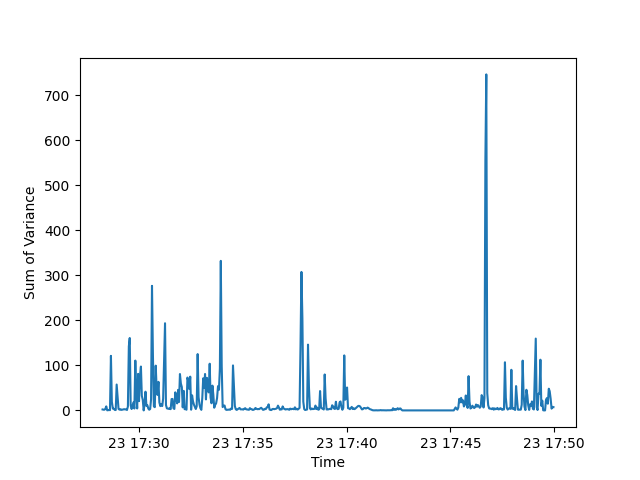

In [36]:
# Get Data set from mission 53 due to better notes on when in breaking 
mission_nc_path = '../microSWIFT_data/mission_53/mission_53.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')

# Define Accelerations 
accel_time = mission_dataset['microSWIFT_44']['IMU']['time']
accel_x = mission_dataset['microSWIFT_44']['IMU']['accel_x']
accel_y = mission_dataset['microSWIFT_44']['IMU']['accel_y']
accel_z = mission_dataset['microSWIFT_44']['IMU']['accel_z']

# Sort Data into short windows of 32 samples
sample_per_window = 32 # This value is chosen from the Brown 2018 paper
imu_sampling_freq = 12 # Units are Hz
time_per_window = sample_per_window * (1/imu_sampling_freq) # Time per each window 
num_samples = len(accel_x)
num_windows = int(num_samples/sample_per_window)
num_samples_to_use = int(num_windows * sample_per_window)
# Reshape the python array to be windowed
accel_time_windowed = accel_time[:num_samples_to_use].reshape(sample_per_window, num_windows, order='F')
accel_x_windowed = accel_x[:num_samples_to_use].reshape(sample_per_window, num_windows, order='F')
accel_y_windowed = accel_y[:num_samples_to_use].reshape(sample_per_window, num_windows, order='F')
accel_z_windowed = accel_z[:num_samples_to_use].reshape(sample_per_window, num_windows, order='F')

# For each window - compute the variance and add together to get breaker index
sum_variance = np.empty(num_windows)
window_time = np.empty(num_windows)
for n in np.arange(num_windows):
    sum_variance[n] = np.var(accel_x_windowed[:,n]) + np.var(accel_y_windowed[:,n]) + np.var(accel_z_windowed[:,n])
    window_time[n] = np.mean(accel_time_windowed[:,n])

# Convert Mean time values to datetimes
window_time_datetime = cftime.num2pydate(window_time, units=mission_dataset['microSWIFT_44']['IMU']['time'].units, calendar=mission_dataset['microSWIFT_44']['IMU']['time'].calendar)


fig_var, ax = plt.subplots()
ax.plot(window_time_datetime, sum_variance)
ax.set_xlabel('Time')
ax.set_ylabel('Sum of Variance')

Text(0, 0.5, 'alpha [m/s^2]')

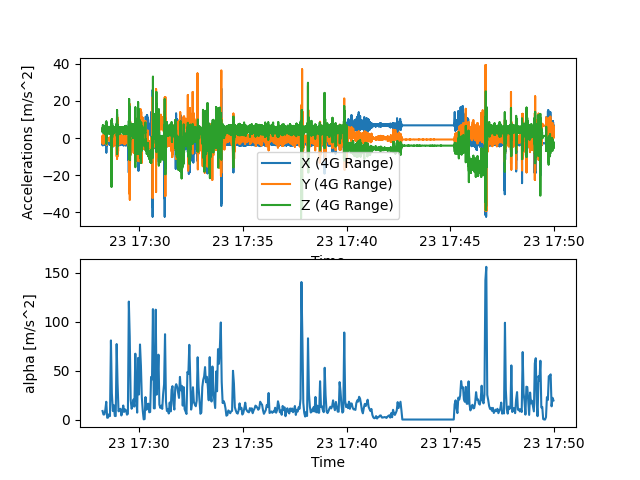

In [74]:
from scipy import fft

# Get Data set from mission 53 due to better notes on when in breaking 
mission_nc_path = '../microSWIFT_data/mission_53/mission_53.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')

# Define Accelerations 
accel_time = mission_dataset['microSWIFT_44']['IMU']['time']
accel_x = mission_dataset['microSWIFT_44']['IMU']['accel_x']
accel_y = mission_dataset['microSWIFT_44']['IMU']['accel_y']
accel_z = mission_dataset['microSWIFT_44']['IMU']['accel_z']

# Sort Data into short windows of 32 samples
samples_per_window = 32 # This value is chosen from the Brown 2018 paper
imu_sampling_freq = 12 # Units are Hz
time_per_window = sample_per_window * (1/imu_sampling_freq) # Time per each window 
num_samples = len(accel_x)
num_windows = int(num_samples/sample_per_window)
num_samples_to_use = int(num_windows * sample_per_window)
# Reshape the python array to be windowed
accel_time_windowed = accel_time[:num_samples_to_use].reshape(samples_per_window, num_windows, order='F')
accel_x_windowed = accel_x[:num_samples_to_use].reshape(samples_per_window, num_windows, order='F')
accel_y_windowed = accel_y[:num_samples_to_use].reshape(samples_per_window, num_windows, order='F')
accel_z_windowed = accel_z[:num_samples_to_use].reshape(samples_per_window, num_windows, order='F')

# For each window - compute the variance and add together to get breaker index
alpha = np.empty(num_windows)
window_time = np.empty(num_windows)
fft_freq = fft.fftshift(fft.fftfreq(samples_per_window, d=1/imu_sampling_freq))
ind_freq_greater_than_2hz = np.argwhere(fft_freq > 2)

# Compute Blackman Taper Window function
blackman_window = np.blackman(samples_per_window)

for n in np.arange(num_windows):
    accel_x_t = np.sum(fft.fftshift(np.abs(fft.fft(1/(2*np.pi) * blackman_window * (accel_x_windowed[:,n] - np.mean(accel_x_windowed[:,n]) ))))[ind_freq_greater_than_2hz])
    accel_y_t = np.sum(fft.fftshift(np.abs(fft.fft(1/(2*np.pi) * blackman_window * (accel_y_windowed[:,n] - np.mean(accel_y_windowed[:,n]) ))))[ind_freq_greater_than_2hz])
    accel_z_t = np.sum(fft.fftshift(np.abs(fft.fft(1/(2*np.pi) * blackman_window * (accel_z_windowed[:,n] - np.mean(accel_z_windowed[:,n]) ))))[ind_freq_greater_than_2hz])
    alpha[n] = accel_x_t + accel_y_t + accel_z_t
    window_time[n] = np.mean(accel_time_windowed[:,n])

# Convert Mean time values to datetimes
window_time_datetime = cftime.num2pydate(window_time, units=mission_dataset['microSWIFT_44']['IMU']['time'].units, calendar=mission_dataset['microSWIFT_44']['IMU']['time'].calendar)
accel_time_datetime = cftime.num2pydate(accel_time, units=mission_dataset['microSWIFT_44']['IMU']['time'].units, calendar=mission_dataset['microSWIFT_44']['IMU']['time'].calendar)

# Plot Alpha Parameters
fig_var, [ax1, ax2] = plt.subplots(2)
# Plot Demeaned accelerations 
ax1.plot(accel_time_datetime, accel_x - np.mean(accel_x), label='X (4G Range)')
ax1.plot(accel_time_datetime, accel_y - np.mean(accel_y), label='Y (4G Range)')
ax1.plot(accel_time_datetime, accel_z - np.mean(accel_z), label='Z (4G Range)')
ax1.set_ylabel('Accelerations [m/s^2]')
ax1.legend()
ax1.set_xlabel('Time')

# Plot Alpha Parameter
ax2.plot(window_time_datetime, alpha)
ax2.set_xlabel('Time')
ax2.set_ylabel('alpha [m/s^2]')

Text(0, 0.5, 'alpha [m/s^2]')

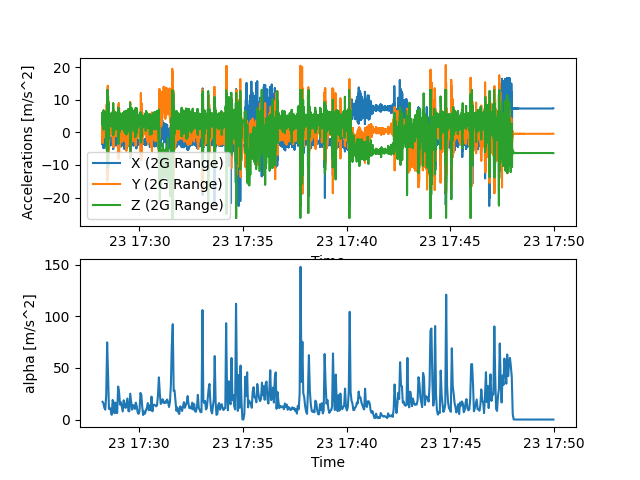

In [76]:
# Get Data set from mission 53 due to better notes on when in breaking 
mission_nc_path = '../microSWIFT_data/mission_53/mission_53.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')

# Define Accelerations 
accel_time = mission_dataset['microSWIFT_31']['IMU']['time']
accel_x = mission_dataset['microSWIFT_31']['IMU']['accel_x']
accel_y = mission_dataset['microSWIFT_31']['IMU']['accel_y']
accel_z = mission_dataset['microSWIFT_31']['IMU']['accel_z']

# Sort Data into short windows of 32 samples
samples_per_window = 32 # This value is chosen from the Brown 2018 paper
imu_sampling_freq = 12 # Units are Hz
time_per_window = sample_per_window * (1/imu_sampling_freq) # Time per each window 
num_samples = len(accel_x)
num_windows = int(num_samples/sample_per_window)
num_samples_to_use = int(num_windows * sample_per_window)
# Reshape the python array to be windowed
accel_time_windowed = accel_time[:num_samples_to_use].reshape(samples_per_window, num_windows, order='F')
accel_x_windowed = accel_x[:num_samples_to_use].reshape(samples_per_window, num_windows, order='F')
accel_y_windowed = accel_y[:num_samples_to_use].reshape(samples_per_window, num_windows, order='F')
accel_z_windowed = accel_z[:num_samples_to_use].reshape(samples_per_window, num_windows, order='F')

# For each window - compute the variance and add together to get breaker index
alpha = np.empty(num_windows)
window_time = np.empty(num_windows)
fft_freq = fft.fftshift(fft.fftfreq(samples_per_window, d=1/imu_sampling_freq))
ind_freq_greater_than_2hz = np.argwhere(fft_freq > 2)

# Compute Blackman Taper Window function
blackman_window = np.blackman(samples_per_window)

for n in np.arange(num_windows):
    accel_x_t = np.sum(fft.fftshift(np.abs(fft.fft(1/(2*np.pi) * blackman_window * (accel_x_windowed[:,n] - np.mean(accel_x_windowed[:,n]) ))))[ind_freq_greater_than_2hz])
    accel_y_t = np.sum(fft.fftshift(np.abs(fft.fft(1/(2*np.pi) * blackman_window * (accel_y_windowed[:,n] - np.mean(accel_y_windowed[:,n]) ))))[ind_freq_greater_than_2hz])
    accel_z_t = np.sum(fft.fftshift(np.abs(fft.fft(1/(2*np.pi) * blackman_window * (accel_z_windowed[:,n] - np.mean(accel_z_windowed[:,n]) ))))[ind_freq_greater_than_2hz])
    alpha[n] = accel_x_t + accel_y_t + accel_z_t
    window_time[n] = np.mean(accel_time_windowed[:,n])

# Convert Mean time values to datetimes
window_time_datetime = cftime.num2pydate(window_time, units=mission_dataset['microSWIFT_31']['IMU']['time'].units, calendar=mission_dataset['microSWIFT_31']['IMU']['time'].calendar)
accel_time_datetime = cftime.num2pydate(accel_time, units=mission_dataset['microSWIFT_31']['IMU']['time'].units, calendar=mission_dataset['microSWIFT_31']['IMU']['time'].calendar)

# Plot Alpha Parameters
fig_var, [ax1, ax2] = plt.subplots(2)
# Plot Demeaned accelerations 
ax1.plot(accel_time_datetime, accel_x - np.mean(accel_x), label='X (2G Range)')
ax1.plot(accel_time_datetime, accel_y - np.mean(accel_y), label='Y (2G Range)')
ax1.plot(accel_time_datetime, accel_z - np.mean(accel_z), label='Z (2G Range)')
ax1.set_ylabel('Accelerations [m/s^2]')
ax1.legend()
ax1.set_xlabel('Time')

# Plot Alpha Parameter
ax2.plot(window_time_datetime, alpha)
ax2.set_xlabel('Time')
ax2.set_ylabel('alpha [m/s^2]')